In [1]:
from matplotlib.pyplot import figure
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import Policy, ema_logging, ScalarOutcome

import pickle
import numpy as np
import pandas as pd
import seaborn as sns


In [2]:
# Define the desired problem formulation here
pf = 3
model, _ = get_model_for_problem_formulation(pf)

In [3]:
#We do not understand yet why we need a reference_value, these values are from the std document of dike_model_simulation.py

reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                    'discount rate 0': 3.5, 'discount rate 1': 3.5,
                    'discount rate 2': 3.5,
                    'ID flood wave shape': 4}
scen1 = {}
#comparing scenario's with the reference to select scenario's fitted for the problem
for key in model.uncertainties:
    name_split = key.name.split('_')

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})

    else:
        scen1.update({key.name: reference_values[name_split[1]]})
        
from ema_workbench import Scenario

ref_scenario = Scenario('reference', **scen1)

### Step 1: Generate optimal policies

In [4]:
from ema_workbench import MultiprocessingEvaluator

from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)

from ema_workbench.em_framework.evaluators import BaseEvaluator

from ema_workbench import Samplers

ema_logging.log_to_stderr(ema_logging.INFO)

#The model is saving the convergence table every 500 nfr, so chose a large number to analyse trends. 

nfe = 150000

#The amount of values for the epsilon list is dependend on the amount of outputs. 
#the larger you choose your epsilon, the more results you will get
#you could chose a lower epsilon in this case. 

len_out = len(model.outcomes.keys()) #This adjusts the size of Epsilon and Hypervolume to the problem formulation
epsilon = [2] * len_out   

#for now there is still a problem with the HyperVolume function. We could decide to not use it because the EpsilonProgress
#is also helpful findig the total amount of policies to establish the convergence of the policie space.

convergence_metrics = [HyperVolume(minimum=[0]*len_out, maximum=[1.01]*len_out),
                       EpsilonProgress()]

#Run ones with Pickle is false to get results, then you could set Pickle on true to avoid unnesecery run time. =) 
use_pickle1 = True
if use_pickle1:
    with open(f"data/MORDM_results1_pf{pf}.pickle","rb") as filehandler:
        results, convergence = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(model) as evaluator:
        #save it as a Tuple 
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                                  epsilons=epsilon,
                                                  convergence=convergence_metrics,
                                                  reference=ref_scenario,
                                                  n_processes=10,
                                                  uncertainty_sampling=Samplers.LHS)
###!!!!!!
#Change the amount of processes accordingly. 10 processes is recommended for 6core CPU. 14 processes for 8 core CPU        
###!!!!!!
    #Save results in Pickle file
    with open(f"data/MORDM_results1_pf{pf}.pickle","wb") as filehandler:
        pickle.dump((results,convergence),filehandler)

[MainProcess/INFO] pool started with 12 workers
100%|████████████████████████████████████████| 100/100 [00:07<00:00, 12.93it/s]
[MainProcess/INFO] optimization completed, found 80 solutions
[MainProcess/INFO] terminating pool


In [5]:
convergence

,hypervolume,epsilon_progress,nfe
0,0.0,0,0
1,0.0,83,100


In [6]:
outcomes = results[list(model.outcomes.keys())] #This makes sure that the outcomes are split from the levers/uncertainties 
outcomes.head()

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,1.295039e+08,0.0,3.002321e+08,0.0,8.296756e+07,0.010627,2.229236e+07,0.00195,1.424481e+08,0.000715,4.004000e+08,0.000000
1,1.542875e+08,0.0,2.848514e+08,0.0,1.236719e+08,0.000000,2.108339e+07,0.00000,1.396070e+08,0.000000,1.317500e+09,0.000000
2,1.904569e+08,0.0,2.106806e+08,0.0,1.032953e+08,0.003056,4.721923e+07,0.00000,6.016090e+07,0.000500,8.958000e+08,907.090231
3,3.239124e+08,0.0,1.100616e+08,0.0,1.283388e+08,0.000000,1.780335e+07,0.00000,6.939222e+07,0.001077,8.009000e+08,397.961455
4,4.229151e+07,0.0,1.562960e+08,0.0,1.321509e+08,0.002639,4.333529e+07,0.00000,9.819535e+07,0.000000,7.889000e+08,346.439339


C:\Users\Thomas\miniconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:197: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


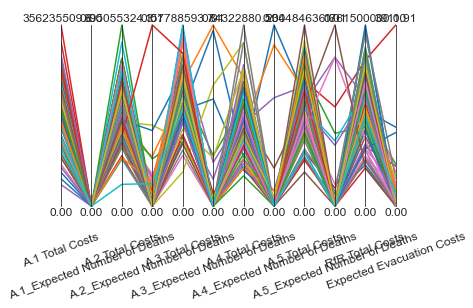

In [7]:
from ema_workbench.analysis import parcoords

#making a pairplot
import matplotlib.pyplot as plt

limits = parcoords.get_limits(outcomes)
limits.loc[0, outcomes.keys()] = 0

axes = parcoords.ParallelAxes(limits, fontsize=12, rot=20)
axes.plot(outcomes)
#plt.savefig(f"images/ParallelAxes_pf{pf}.svg")
plt.show()

In [8]:
convergence
#as seen, the hypervolume stays 0, this indicates an error. 

,hypervolume,epsilon_progress,nfe
0,0.0,0,0
1,0.0,83,100


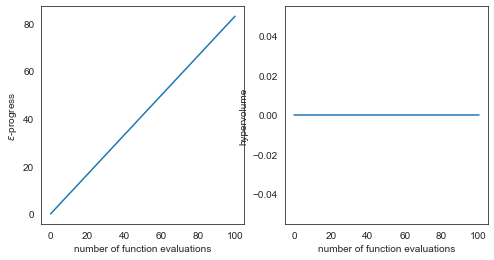

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

### Step 2: Re-evaluate candidate solutions under uncertainty

In [10]:
pf = 2
model, _ = get_model_for_problem_formulation(pf)

In [11]:
from ema_workbench import Samplers

ema_logging.log_to_stderr(ema_logging.INFO)

#The model is saving the convergence table every 500 nfr, so chose a large number to analyse trends. 

nfe = 100

#The amount of values for the epsilon list is dependend on the amount of outputs. 
#the larger you choose your epsilon, the more results you will get
#you could chose a lower epsilon in this case. 

len_out = len(model.outcomes.keys()) #This adjusts the size of Epsilon and Hypervolume to the problem formulation
epsilon = [2] * len_out   

#for now there is still a problem with the HyperVolume function. We could decide to not use it because the EpsilonProgress
#is also helpful findig the total amount of policies to establish the convergence of the policie space.

convergence_metrics = [HyperVolume(minimum=[0]*len_out, maximum=[1.01]*len_out),
                       EpsilonProgress()]

#Run ones with Pickle is false to get results, then you could set Pickle on true to avoid unnesecery run time. =) 
use_pickle1 = True
if use_pickle1:
    with open(f"data/MORDM_results1_pf{pf}.pickle","rb") as filehandler:
        results, convergence = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(model) as evaluator:
        #save it as a Tuple 
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                                  epsilons=epsilon,
                                                  convergence=convergence_metrics,
                                                  reference=ref_scenario,
                                                  n_processes=10,
                                                  uncertainty_sampling=Samplers.LHS)
###!!!!!!
#Change the amount of processes accordingly. 10 processes is recommended for 6core CPU. 14 processes for 8 core CPU        
###!!!!!!
    #Save results in Pickle file
    with open(f"data/MORDM_results1_pf{pf}.pickle","wb") as filehandler:
        pickle.dump((results,convergence),filehandler)

[MainProcess/INFO] pool started with 12 workers
100%|████████████████████████████████████████| 100/100 [00:07<00:00, 12.86it/s]
[MainProcess/INFO] optimization completed, found 6 solutions
[MainProcess/INFO] terminating pool


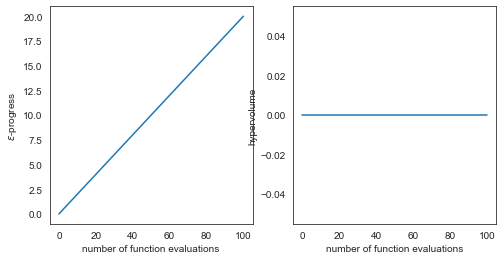

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

In [13]:
results["Expected Annual Damage"] <= 1000000

0    False
1     True
2    False
3     True
4     True
5    False
Name: Expected Annual Damage, dtype: bool

In [14]:
logical = (results["Expected Number of Deaths"] <= 0.01) & (results["Expected Annual Damage"] <= 1000000)
np.sum(logical)

3

In [15]:
results[logical].head()

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
1,1,0,1,0,0,0,0,1,1,0,...,9,1,5,2,3,183075.332855,5.204865e+08,729100000.0,12.353954,0.000018
3,1,0,1,0,0,0,1,1,1,0,...,2,4,2,8,7,0.000000,5.922955e+08,503700000.0,0.000000,0.000000
4,0,0,0,0,1,1,0,1,0,0,...,10,4,3,1,0,0.000000,4.510465e+08,964800000.0,0.000000,0.000000


In [16]:
policies = results[logical]
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies.head()

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
1,1,0,1,0,0,0,0,1,1,0,...,2,9,0,2,1,9,1,5,2,3
3,1,0,1,0,0,0,1,1,1,0,...,3,2,6,8,2,2,4,2,8,7
4,0,0,0,0,1,1,0,1,0,0,...,0,2,1,2,5,10,4,3,1,0


In [17]:
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [18]:
# True, use results in pickle file; False, run MultiprocessingEvaluator
use_pickle2 = True

if use_pickle2:
    with open(f"data/MORDM_results2_pf{pf}.pickle","rb") as filehandler:
        results2 = pickle.load(filehandler)

else:
    # pass the policies list to EMA workbench experiment runs
    n_scenarios = 250
    with MultiprocessingEvaluator(model) as evaluator:
        results2 = evaluator.perform_experiments(n_scenarios, policies_to_evaluate)
    # Save results in Pickle file
    with open(f"data/MORDM_results2_pf{pf}.pickle","wb") as filehandler:
        pickle.dump(results2,filehandler)

In [19]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [20]:
experiments2, outcomes2 = results2

overall_scores = {}
for policy in np.unique(experiments2['policy']):
    scores = {}
    
    logical = experiments2['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes2[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
105,4.475401e+17,4.293146,0.0,2.109472e+07,0.025131
113,3.013149e+17,5.862920,0.0,6.426463e+07,0.004320
26,4.999168e+17,0.000000,0.0,1.592072e+08,0.004160
27,4.523499e+17,14.990002,0.0,6.174920e+07,0.004898
42,3.063223e+17,12.290636,0.0,6.709721e+07,0.004698
81,5.566718e+17,1.791054,0.0,3.387948e+07,0.034304


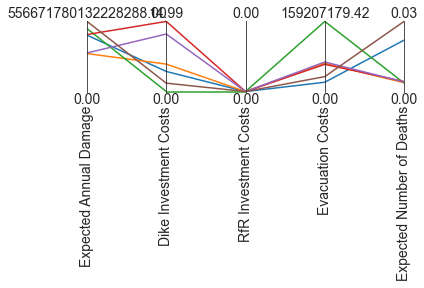

In [21]:
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, data.keys()] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

### Step 3: Give scores using maximum regret

In [22]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [23]:
overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments2['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes2[outcome.name], 
                         "policy":experiments2['policy'],
                         "scenario":experiments2['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

C:\Users\Thomas\AppData\Local\Temp\ipykernel_10732\727777919.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\Thomas\AppData\Local\Temp\ipykernel_10732\727777919.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\Thomas\AppData\Local\Temp\ipykernel_10732\727777919.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\Thomas\AppData\Local\Temp\ipykernel_10732\7

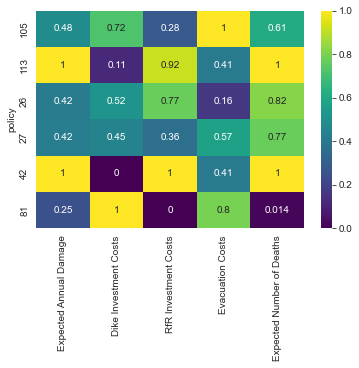

In [24]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

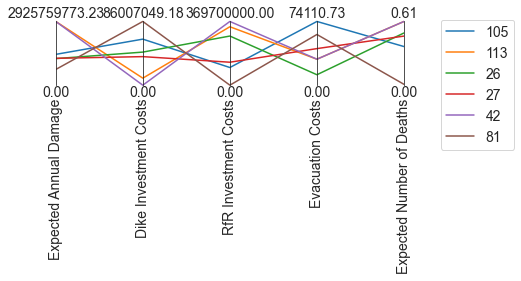

In [25]:
colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, data.keys()] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()

In [26]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

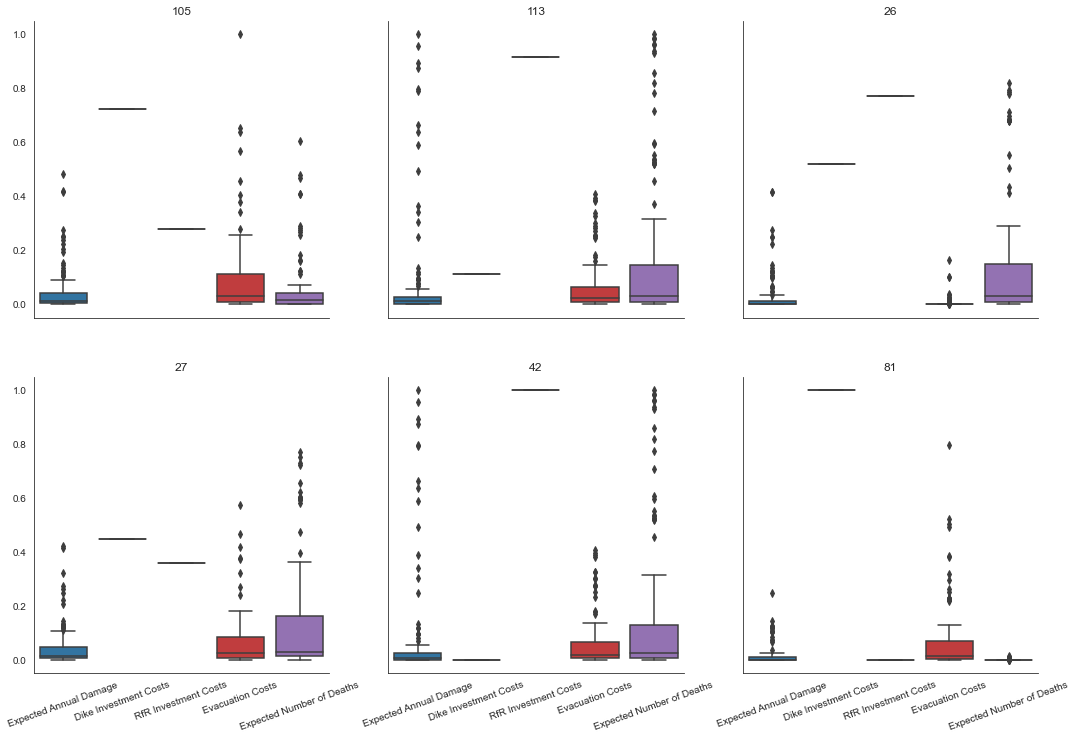

In [27]:
# this generates a 2 by 2 axes grid, with a shared X and Y axis
# accross all plots
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(18,12), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 
axes = [axes[0,0], axes[0,1], axes[0,2],
        axes[1,0], axes[1,1], axes[1,2]]

# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))

    # Rotate x-axis labels slightly to make them redable
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
plt.show()